<a href="https://colab.research.google.com/github/Sjleerodls/Data_Analysis/blob/main/lab_da/ml17_ann_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fashion MNIST 이미지 분류

# Imports

In [97]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [98]:
tf.__version__

'2.19.0'

In [99]:
keras.__version__

'3.10.0'

In [100]:
print(keras.config.backend())       # Keras 라이브러리에서 신경망 계산을 할 때 필요한 라이브러리.

tensorflow


In [101]:
print(tf.config.list_physical_devices())    # CPU/GPU/TPU 사용 여부 확인

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Keras 라이브러리는 GPU 연산을 직접 수행하지 않음. 대신에 GPU 연산을 수행하는 다른 딥러닝 라이브러리를 백엔드(backend)로 활용함.

* Keras에서 사용할 수 있는 백엔드 종류
    * TensorFlow - Google에서 만든 텐서(Tensor) 연산을 빠르게 수행하기 위한 라이브러리.
    * PyTorch - Meta(페이스북)에서 만든 딥러닝 라이브러리 -> 리눅스 재단으로 오픈소스로 공개.
* Keras
    * 여러가지 백엔드를 사용해서 신경망을 쉽게 만들고 사용할 수 있도록 만든 고급 라이브러리.
    * 2.3.1 버전 이후부터는 TensorFlow만 단일 백엔드로 사용하도록 기능 변경.
    * 3.0 버전부터 다시 멀티 백엔드 정책으로 바뀜.

# Fashion MNIST 데이터 셋

10가지 패션 아이템으로 이루어진 60,00개 훈련 셋/레이블, 10,000개 테스트 셋/레이블.

In [102]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
# (훈련 셋, 훈련 레이블), (테스트 셋, 테스트 레이블)

In [103]:
x_train.shape   # (n_samples, image_width, image_height)

(60000, 28, 28)

In [104]:
y_train.shape

(60000,)

In [105]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [106]:
x_test.shape

(10000, 28, 28)

In [107]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

데이터셋의 이미지를 시각화 해 보세요.

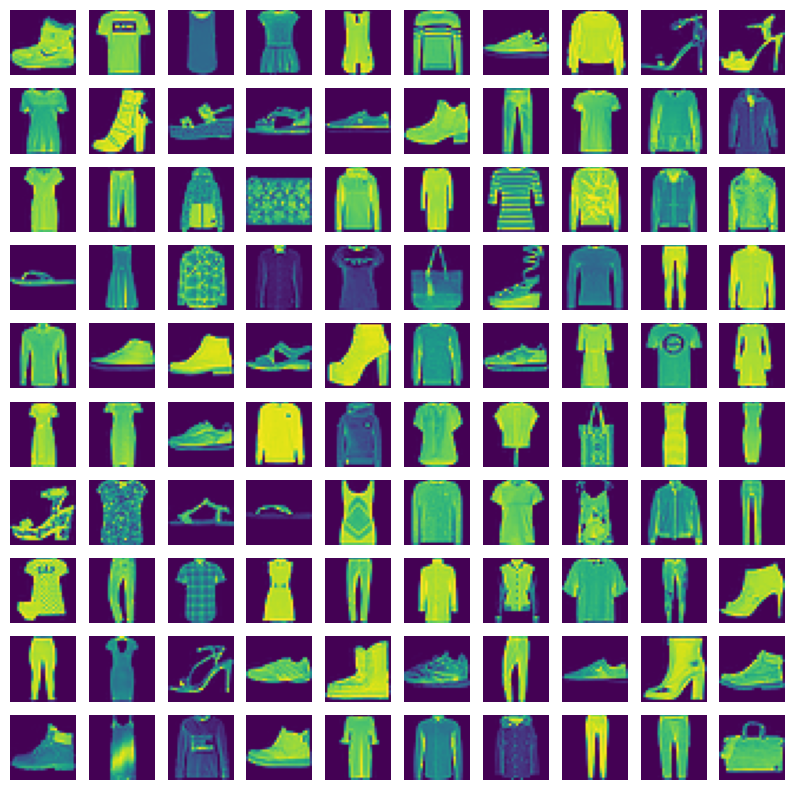

In [108]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        ax[i, j].imshow(x_train[i*10 + j])
        ax[i, j].axis('off')

plt.show()

In [109]:
def plot_fashion_mnist2(arr, ncols=10):
    # arr : (samples, width, height) shape의 3차원 배열
    # ncols : subplot axis의 컬럼 개수.
    n = len(arr)    # 출력할 이미지 개수
    nrows = int(np.ceil(n / ncols))    # subplot Axis 행 개수.
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols, nrows))

    for i in range(nrows):
        for j in range(ncols):
            idx = i * ncols + j     # arr에서 선택할 이미지 인덱스.
            if nrows == 1 or ncols == 1:    # ax가 1차원 배열인 경우
                if idx < n:
                    ax[idx].imshow(arr[idx], cmap=plt.cm.binary)
                ax[idx].axis('off')
            else:   # ax가 2차원 배열인 경우
                if idx < n:
                    ax[i, j].imshow(arr[idx], cmap=plt.cm.binary)
                ax[i, j].axis('off')

    plt.show()

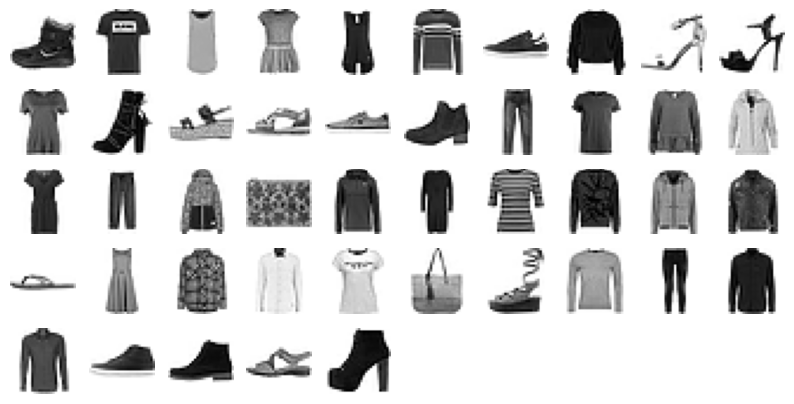

In [110]:
plot_fashion_mnist2(x_train[:45])

# 훈련 셋/레이블을 훈련 셋과 검증 셋으로 분리

In [111]:
train_data, val_data, train_target, val_target = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [112]:
print(train_data.shape)
print(train_target.shape)
print(np.unique(train_target, return_counts=True))

(48000, 28, 28)
(48000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800]))


In [113]:
print(val_data.shape)
print(val_target.shape)
print(np.unique(val_target, return_counts=True))

(12000, 28, 28)
(12000,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200]))


# SGD Classifier

In [114]:
train_data[0]   #> 각 픽셀의 값들이 0(white) ~ 255(white)

array([[  0,   0,   0,   0,   1,   1,   0,   0,   0,  25,  55,   0,   0,
          0,   0,   0,   0,  43,  24,   0,   0,   0,   1,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   1,   1,   0,  25, 147, 189, 181,  96,  51,
         49,  55,  37,  76, 217, 172, 125,  20,   0,   2,   1,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   3,   0,  82, 206, 202, 190, 178, 188, 239,
        152,  99, 199, 201, 162, 176, 192, 185,  71,   0,   2,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0, 202, 196, 181, 188, 183, 169, 179,
        160, 107, 198, 166, 167, 178, 170, 183, 166,   0,   0,   1,   0,
          0,   0],
       [  0,   0,   0,   1,   0,  48, 216, 184, 185, 185, 190, 175, 164,
        188, 198, 188, 157, 183, 176, 171, 167, 175,  26,   0,   2,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  90, 224, 183, 185, 184, 183, 190, 164,
        169, 193, 158, 170, 174, 176, 175, 165, 180,  62,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 123, 228, 184, 180, 183, 178, 183, 172,
        172, 172, 161, 179, 170, 174, 175, 165, 181, 106,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 156, 229, 188, 175, 178, 175, 175, 190,
        157, 157, 180, 169, 169, 172, 171, 161, 179, 143,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 181, 228, 190, 174, 174, 176, 175, 197,
        167, 167, 183, 166, 169, 171, 170, 162, 175, 172,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   6, 175, 221, 192, 170, 174, 176, 175, 193,
        176, 172, 175, 167, 169, 169, 167, 160, 169, 196,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  23, 184, 216, 206, 164, 175, 176, 175, 192,
        178, 175, 174, 167, 166, 169, 169, 165, 169, 175,   6,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  53, 189, 208, 219, 161, 176, 176, 175, 190,
        181, 178, 172, 169, 165, 170, 169, 166, 167, 183,  26,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  84, 194, 207, 216, 157, 176, 175, 176, 193,
        183, 180, 172, 167, 167, 166, 170, 165, 167, 185,  61,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 114, 193, 211, 207, 157, 175, 175, 176, 196,
        183, 181, 172, 166, 166, 165, 170, 164, 169, 187,  88,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 155, 192, 219, 194, 161, 172, 178, 176, 197,
        185, 181, 169, 166, 165, 165, 171, 164, 171, 184, 108,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 181, 192, 225, 185, 162, 172, 179, 176, 199,
        185, 183, 169, 166, 164, 164, 172, 161, 170, 184, 135,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 210, 189, 233, 180, 161, 171, 179, 179, 201,
        185, 190, 166, 166, 164, 164, 176, 158, 171, 183, 155,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 229, 184, 234, 176, 164, 169, 180, 183, 198,
        185, 193, 166, 167, 164, 165, 179, 157, 176, 179, 174,   0,   0,
          0,   0],
       [  0,   0,   0,   2, 237, 183, 237, 171, 166, 167, 178, 188, 196,
        187, 196, 164, 166, 165, 166, 179, 157, 178, 176, 185,   2,   0,
          0,   0],
       [  0,   0,   0,  24, 246, 184, 255, 172, 166, 169, 180, 192, 196,
        189, 201, 161, 164, 165, 165, 181, 161, 181, 176, 189,  17,   0,
          0,   0],
       [  0,   0,   0,  52, 247, 187, 238, 166, 170, 170, 180, 198, 193,
        189, 207, 160, 165, 165, 164, 180, 162, 187, 175, 192,  52,   0,
          0,   0],
       [  0,   0,   0,  82, 215, 192, 239, 158, 169, 174, 179, 207, 189,
        187, 213, 160, 167, 166, 165, 181, 169, 190, 170, 192,  73,   0,
          0,   0],
       [  0,   0,   0, 102, 212, 201, 212, 166, 169, 171, 179, 217, 189,
        187, 217, 157, 170, 167, 166, 178, 171, 196, 169, 171,  84,   0,
          0,   0],
       [  0,   0,   0, 166, 211, 213, 193, 164, 170, 170, 180, 226, 181,
        187, 228, 157, 167, 167, 158, 188, 196, 128, 170, 179, 128,   0,
          0,   0],
       [  0,   0,   0,  35,  92, 129, 19

In [115]:
# 훈련 셋의 픽셀 값을 0 ~ 1 사이의 값으로 스케일링 -> 확률적 경사 하강법 성능을 높이기 위해서.
train_data_scaled = train_data / 255.0

In [116]:
train_data_scaled[0]

array([[0.        , 0.        , 0.        , 0.        , 0.00392157,
        0.00392157, 0.        , 0.        , 0.        , 0.09803922,
        0.21568627, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.16862745, 0.09411765, 0.        ,
        0.        , 0.        , 0.00392157, 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00392157, 0.00392157,
        0.00392157, 0.        , 0.09803922, 0.57647059, 0.74117647,
        0.70980392, 0.37647059, 0.2       , 0.19215686, 0.21568627,
        0.14509804, 0.29803922, 0.85098039, 0.6745098 , 0.49019608,
        0.07843137, 0.        , 0.00784314, 0.00392157, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00392157, 0.01176471,
        0.        , 0.32156863, 0.80784314, 0.79215686, 0.74509804,
        0.69803922, 0.7372549 , 0.9372549 , 0.59607843, 0.38823529,
        0.78039216, 0.7882

In [117]:
sgd = SGDClassifier(loss='log_loss', random_state=42, n_jobs=-1)    # n_jobs:코어를 다 사용하겠다!!

In [118]:
sgd.fit(X=train_data_scaled.reshape(48000, -1), y=train_target)

SGDClassifier(loss='log_loss', n_jobs=-1, random_state=42)

In [119]:
sgd.intercept_  #> shape : (10,)

array([ -1.54024535,  -4.97085256,  -2.45411884,  -1.5496291 ,
        -4.94592029,   3.66151889,  -1.47955462,  -1.90241534,
        -4.40078057, -25.19876253])

In [120]:
sgd.coef_.shape #> (10, 784)

(10, 784)

In [121]:
predict_probas = sgd.predict_proba(X=train_data_scaled.reshape(48000, -1))

In [122]:
predict_probas.shape    #> (48_000, 10)

(48000, 10)

In [123]:
predict_probas[:2]

array([[1.20888251e-02, 1.05549631e-05, 2.30094285e-01, 3.41231387e-03,
        4.86284532e-02, 3.96063160e-10, 6.91742929e-01, 1.54454383e-17,
        1.40226378e-02, 1.05805064e-16],
       [7.53889861e-01, 1.20438290e-04, 4.89841116e-05, 2.88644150e-04,
        7.52168267e-02, 4.15812599e-17, 1.69806662e-01, 2.22627871e-15,
        6.28584469e-04, 3.41774283e-15]])

In [124]:
predicts = sgd.predict(X=train_data_scaled.reshape(48000, -1))

In [125]:
predicts.shape  #> (48_000,)

(48000,)

In [126]:
accuracy_score(train_target, predicts)       # 훈련 셋 정확도

0.8518125

# 검증셋

In [127]:
 # 검증 셋의 모든 픽셀을 0 ~ 1 사이로 스케일링
 val_data_scaled = val_data / 255.0
 # 검증 셋의 예측값
 val_predicts = sgd.predict(X=val_data_scaled.reshape(12000, -1))
 # 검증 셋의 정확도
 accuracy_score(y_true=val_target, y_pred=val_predicts)

0.8468333333333333

# 신경망

입력층과 출력층만 갖는 신경망을 Keras 라이브러리를 사용해서 만들고 테스트.

In [128]:
tr_data_scaled_flat = train_data_scaled.reshape((48000, -1))      #> shape : (48_000, 784)
val_data_scaled_flat = val_data_scaled.reshape((12000, -1))       #> shape : (12_000, 784)

In [129]:
train_target.shape

(48000,)

In [130]:
Input = keras.layers.Input(shape=(784,))

In [131]:
hidden1 = keras.layers.Dense(units=100, activation='softmax')

In [132]:
model = keras.Sequential()
model.add(Input)
model.add(hidden1)

In [133]:
model.summary()
#> 모델 파라미터 개수 = (784 weight * 100 output) + 100 bias = 78,500

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 100)            │        78,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,500 (306.64 KB)

 Trainable params: 78,500 (306.64 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
# model compile
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [135]:
print(tr_data_scaled_flat.shape)
print(train_target.shape)

(48000, 784)
(48000,)


In [136]:
# model training
model.fit(tr_data_scaled_flat, train_target, epochs=10)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7257 - loss: 0.8593
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8391 - loss: 0.4808
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8407 - loss: 0.4673
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8497 - loss: 0.4406
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8503 - loss: 0.4434
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8548 - loss: 0.4289
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8574 - loss: 0.4231
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8575 - loss: 0.4243
Epoch 9/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8615 - loss: 0.4099
Epoch 10/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8597 - loss: 0.4144


In [137]:
# weights
model.weights

[<Variable path=sequential_4/dense_8/kernel, shape=(784, 100), dtype=float32, value=[[ 0.04194731 -0.06803552 -0.01658448 ...  0.01759273  0.02807936
    0.07069552]
  [-0.00374842 -0.02318942 -0.07268151 ... -0.03465929 -0.00283279
   -0.04957256]
  [-0.00079076  0.07127483 -0.0898052  ...  0.01756163 -0.04233875
    0.0755704 ]
  ...
  [-0.33939123 -0.06422858  0.06984016 ... -0.04761986  0.00626733
   -0.04288217]
  [-0.25048506  0.07905203 -0.01799914 ... -0.04177242  0.02013919
   -0.07264262]
  [ 0.08543294 -0.06069507  0.17069863 ...  0.06363968  0.00607494
   -0.0650355 ]]>,
 <Variable path=sequential_4/dense_8/bias, shape=(100,), dtype=float32, value=[ 0.40513006 -0.74018866 -0.09486269  0.6495711  -0.95222217  2.4787726
   0.39101794 -0.12093463 -0.46099705 -1.5652931  -1.0070435  -0.99882233
  -1.006111   -1.0054599  -0.9944264  -0.9925004  -1.0026286  -0.98979
  -1.000259   -0.9995434  -1.0036207  -0.9963593  -0.9958248  -1.0032105
  -1.0039015  -0.99819314 -1.0020459  -1.0

In [138]:
predicts = model.predict(x=tr_data_scaled_flat)
#> 48,000개 이미지의 각 레이블이 될 확률을 리턴.

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [139]:
predicts.shape  #> (48_000 이미지 샘플, 100개 확률)

(48000, 100)

In [140]:
predicts[:2]

array([[5.2207545e-03, 1.9670815e-06, 2.8630278e-01, 3.9847540e-03,
        3.0206725e-02, 8.0403069e-15, 6.7317772e-01, 1.1577161e-21,
        1.1053407e-03, 1.2361020e-21, 5.7999676e-16, 4.9705227e-16,
        4.9761005e-16, 5.2754340e-16, 4.3420370e-16, 7.7371526e-16,
        6.4492136e-16, 7.6174891e-16, 6.9105024e-16, 2.7833751e-16,
        5.1174581e-16, 5.9544309e-16, 5.0600954e-16, 5.2637348e-16,
        6.1744340e-16, 6.0160769e-16, 3.8153959e-16, 5.6874175e-16,
        4.6036151e-16, 7.0801573e-16, 2.8117944e-16, 8.5348940e-16,
        1.0503867e-15, 1.0590006e-15, 5.6146209e-16, 5.8801001e-16,
        8.3173299e-16, 6.5280734e-16, 4.7780446e-16, 5.2679732e-16,
        5.4340562e-16, 1.1284577e-15, 4.6246495e-16, 4.2008279e-16,
        3.7161374e-16, 4.0513475e-16, 1.1849030e-15, 1.2962780e-15,
        4.1702675e-16, 1.1199066e-15, 9.4743346e-16, 4.3290043e-16,
        4.8274748e-16, 6.6490869e-16, 5.2698621e-16, 9.8663414e-16,
        5.4292906e-16, 5.5351496e-16, 7.1355522e

In [141]:
model.evaluate(val_data_scaled_flat, val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8581 - loss: 0.4199


[0.4161984920501709, 0.8611666560173035]

In [142]:
y_pred_label = (y_pred > 0.5).astype('int').ravel()
y_pred_label

NameError: name 'y_pred' is not defined

In [143]:
accuracy_score(val_target, y_pred_label)

NameError: name 'y_pred_label' is not defined

In [144]:
tr_pred_labels = predicts.argmax(axis=1)    # 최댓값의 인덱스를 리턴.

In [145]:
tr_pred_labels.shape

(48000,)

In [146]:
tr_pred_labels[:2]

array([6, 0])

In [147]:
accuracy_score(y_true=train_target, y_pred=tr_pred_labels)

0.8644583333333333

In [148]:
# 훈련 셋 평가
model.evaluate(x=tr_data_scaled_flat, y=train_target)
#> [loss(손실), accuracy(정확도)]

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8650 - loss: 0.3970


[0.40423208475112915, 0.8644583225250244]

In [149]:
# 검증 셋 평가
model.evaluate(x=val_data_scaled_flat, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8581 - loss: 0.4199


[0.4161984920501709, 0.8611666560173035]

# 활성화 함수(Activation Function)

* 활성화 함수 : 신경망의 각 층(layer)에서 출력을 내보내는 함수.
* 신경망의 은닉층(hidden layer)에서 선형함수를 사용하면 여러 개의 층을 연결하는 효과가 없고, 단일 층을 사용하는 것과 같아짐.
* 은닉층에서는 비선형 함수를 활성화 함수로 사용.

## Sigmoid

$
\text{sigmoid}(x) = \dfrac{1}{1 + \exp(-x)}
$

In [150]:
xvals = np.arange(-5, 5, 0.0001)

In [151]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [152]:
yvals = sigmoid(xvals)

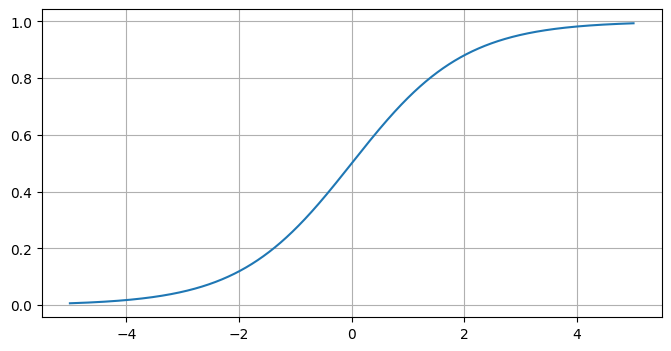

In [153]:
plt.figure(figsize=(8,4))
plt.plot(xvals, yvals)
plt.grid()
plt.show()

## Hyperbolic tangent

In [154]:
def plot_activation_fn(fn):
    xvals = np.arange(-5, 5, 0.0001)
    yvals = fn(xvals)
    plt.figure(figsize=(8,4))
    plt.plot(xvals, yvals)
    plt.grid()
    plt.show()

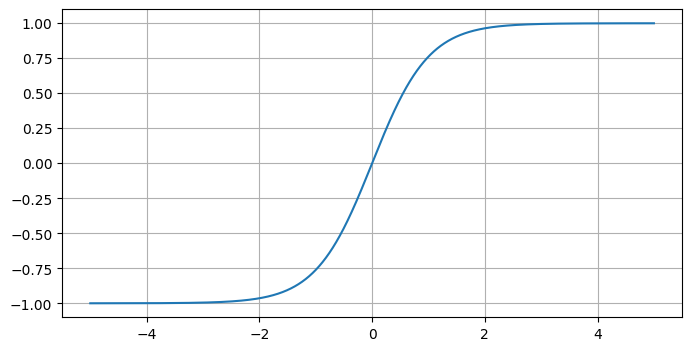

In [155]:
plot_activation_fn(np.tanh)

## ReLU(Rectified Linear Unit)

*   입력값이 양수이면 마치 활성화 함수가 없는 것처럼 입력값 그대로 출력으로 내보냄.
*   입력값이 음수이면 출력값을 0으로 만듦.
*   이미지 처리를 할 때 좋은 성능을 낸다고 알려져 있음.

$
\text{ReLU}(x) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    0 & \text{for } x \lt 0
\end{cases}
$

In [156]:
def relu(x):
    return np.maximum(x, 0)

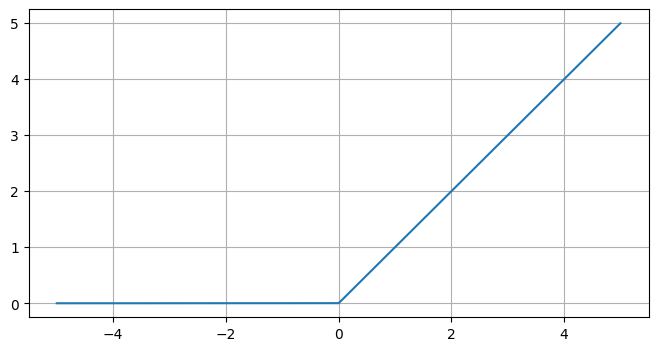

In [157]:
plot_activation_fn(relu)

## Leaky ReLU

$
\text{LeakyReLU}(x, \alpha) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    \alpha x & \text{for } x \lt 0
\end{cases}
$

In [158]:
def leaky_relu(x, alpha=0.1):
    # 0 <= alpha <= 1
    return np.maximum(x, alpha * x)

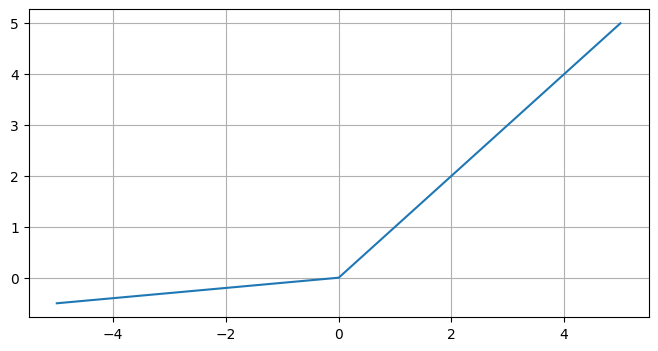

In [159]:
plot_activation_fn(leaky_relu)

## ELU(Exponential Linear Unit)

$
\text{ELU}(x, \alpha) =
\begin{cases}
    x & \text{for } x \ge 0 \\
    \alpha (\exp(x) - 1) & \text{for } x \lt 0
\end{cases}
$

In [160]:
def elu(arr, alpha=1):
    # 0 <= alpha
    result = []
    for x in arr:
        if x >= 0:
            result.append(x)
        else:
            result.append(alpha * (np.exp(x) - 1))
    return np.array(result)

In [161]:
def elu(x, alpha=1):
    return np.where(x >= 0, x, alpha * (np.exp(x) - 1))

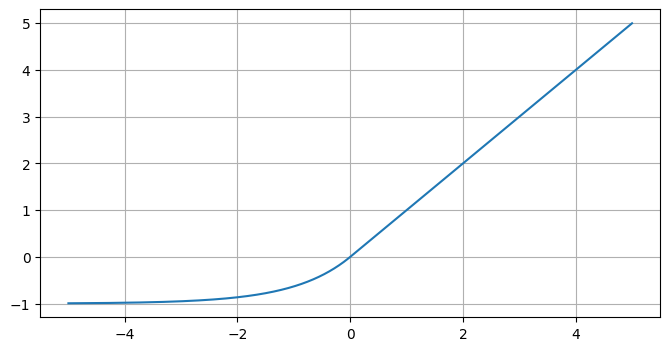

In [162]:
plot_activation_fn(elu)

은닉층에서의 활성화 함수 선택 : ELU > LeakyReLU > ReLU > tanh > sigmoid

# ReLU를 활성화함수로 사용하는 은닉층

In [163]:
model = keras.Sequential()

In [164]:
model.add(keras.Input(shape=(28, 2)))   # 입력층

In [165]:
model.add(keras.layers.Flatten())   # (28, 28) shape의 배열을 (784,) shape으로 변환

In [166]:
# 100개 unit을 갖는, ReLU를 활성화 함수로 사용하는 은닉층을 추가
model.add(keras.layers.Dense(units=100, activation='relu'))

In [167]:
# 출력층 - 다중 클래스 분류. 10개의 unit을 갖고 softmax를 활성화 함수로 사용하는 층
model.add(keras.layers.Dense(units=10, activation='softmax'))

In [168]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 100)            │         5,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,710 (26.21 KB)

 Trainable params: 6,710 (26.21 KB)

 Non-trainable params: 0 (0.00 B)

In [169]:
# 모델 컴파일
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [170]:
# 모델 훈련
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 56, but received input with shape (32, 784)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 28, 28), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [171]:
# 모델 평가 - 훈련 셋의 손실/정확도
model.evaluate(x=train_data_scaled, y=train_target)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 56, but received input with shape (32, 784)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 28, 28), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [172]:
# 모델 평가 - 검증 셋의 손실/정확도
model.evaluate(x=val_data_scaled, y=val_target)

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_9" is incompatible with the layer: expected axis -1 of input shape to have value 56, but received input with shape (32, 784)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 28, 28), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

# ELU를 활성화함수로 사용하는 은닉층

# Optimizer

* 경사 하강법(Gradient Descent)
    * 손실 함수를 최소로 만드는 가중치들을 찾는 방법.

$
w_{next} = w_{init} - 학습률 \cdot 기울기
$

* 아주 큰 신경망인 경우는 모델 훈련을 통해서 찾아야 하는 모델 파라미터들의 개수가 매우 많음.
* 모델 파라미터들의 개수가 많을 수록 훈련 속도가 심각하게 느려질 수 있음.
* 훈련 속도를 높이는 방법 :
    * 좋은 초기화 전략 사용하기
    * 좋은 활성화 함수 사용하기
    * 배치 정규화 사용하기
    * 사전 훈련된 네트워크(신경망)의 일부를 재사용.
    * 일반적인 경사 하강법 대신 더 빠른 옵티마이저를 사용하기.
* 확률적 경사 하강법(SGD)의 변종 옵티마이저
    * 학습률(learning_rate) 파라미터를 변경.
    * 모멘텀 최적화(momentum optimization) : 모멘텀(momentum) 파라미터 값을 0보다 큰 값으로 변경.
    * 네스테로프 가속 경사(Nesterov Accelerated Gradient, NAG) : nesterov 파라미터를 True로 설정.
* 적응형 학습률(adaptive learning rate) : 학습할 때 마다 학습률을 변화시킴.
    * RMSprop(Root Mean Squared Propagation) : Sequential 클래스의 compile 메서드의 optimizer 기본값.
    * Adam(Adaptive Momentum Estimation) : 모멘텀 최적화 + RMSprop
    * Nadam : Adam + Nesterov

## SGD optimizer

In [173]:
def create_model(layers=None):
    # layers : keras.layers 객체들의 배열/리스트.
    model = keras.Sequential()  # Sequential 모델 생성
    model.add(keras.Input(shape=(28, 28)))  # 입력층 추가
    model.add(keras.layers.Flatten())   # Flatten layer 추가
    model.add(keras.layers.Dense(units=100, activation='relu')) # 첫번째 은닉층 추가
    if layers:  # 아규먼트로 전달된 은닉층들이 있으면
        for layer in layers:
            model.add(layer)
    model.add(keras.layers.Dense(units=10, activation='softmax'))   # 출력층 추가

    return model

In [174]:
model = create_model()

In [175]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [176]:
# 옵티마이저 : 학습률 변경, 모멘텀 최적화, 네스테로프 가속 경사
op = keras.optimizers.SGD(learning_rate=0.02, momentum=0.1, nesterov=True)
model.compile(optimizer=op, loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [177]:
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.8824 - sparse_categorical_accuracy: 0.7119
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5007 - sparse_categorical_accuracy: 0.8261
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4596 - sparse_categorical_accuracy: 0.8416
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4205 - sparse_categorical_accuracy: 0.8546
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4086 - sparse_categorical_accuracy: 0.8569


In [178]:
model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3799 - sparse_categorical_accuracy: 0.8670


[0.3866463303565979, 0.8652499914169312]

In [179]:
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3962 - sparse_categorical_accuracy: 0.8580


[0.39312678575515747, 0.8630833625793457]

## Adam optimizer

* `learning_rate` 파라미터 : 학습률
* `beta_1`, `beta_2` 파라미터 : 모멘텀 최적화와 관련된 파라미터.
* `epsilon` 파라미터 : 적응형 학습률과 관련된 파라미터.

In [180]:
model = create_model()

In [181]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [182]:
model.fit(x=train_data_scaled, y=train_target, epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.6659 - sparse_categorical_accuracy: 0.7660
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.4032 - sparse_categorical_accuracy: 0.8521
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3514 - sparse_categorical_accuracy: 0.8732
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.3234 - sparse_categorical_accuracy: 0.8836
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3071 - sparse_categorical_accuracy: 0.8880


In [183]:
model.evaluate(x=train_data_scaled, y=train_target)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2780 - sparse_categorical_accuracy: 0.8949


[0.2813168466091156, 0.895354151725769]

In [184]:
# 과적합 확인
model.evaluate(x=val_data_scaled, y=val_target)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3207 - sparse_categorical_accuracy: 0.8845


[0.32638004422187805, 0.8836666941642761]